<a href="https://colab.research.google.com/github/andres-tovar-purdue/materials/blob/main/HGP_BO_1D_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

White, G.M., A.P. Siegel, and A. Tovar. Optimizing Thermoplastic Starch Film with Heteroscedastic Gaussian Processes in Bayesian Experimental Design Framework. *Materials*, Special Issue: Modelling, Simulation and Optimisation of Non-typical and Innovative Materials, 2024.

**Section 3.5: Numerical Example.** Bayesian optimizaiton of noisy Forrester's fuction.

In [ ]:
!pip install gpflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import tensorflow
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import pandas as pd

In [ ]:
# Vanilla GP model
def train_gp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

def train_gp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, variables=model.trainable_variables)
    return model

def train_pgp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=0.3)
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.Matern32())
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

def train_pgp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=0.3)
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.Matern32())
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model


In [ ]:
# Expected Improvement function for minimization
from scipy.stats import norm
def expected_improvement(y_best, f_mean, f_std):
    delta = y_best - f_mean
    with np.errstate(divide='ignore'):
        Z = delta / f_std
        ei = delta * norm.cdf(Z) + f_std * norm.pdf(Z)
        ei[f_std == 0.0] = 0.0
    return ei


In [ ]:
# Function to calculate y based on the Forrester function
def calculate_y_true(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

def noise_var_fun(x):
  return 10*(x - 0.3)**2

def calculate_y_noisy(x):
    true_value = calculate_y_true(x)
    noise_variance = noise_var_fun(x)
    noise_value = np.random.normal(0, np.sqrt(noise_variance), x.shape)
    return true_value + noise_value

In [ ]:
def gp_noisy_plot(x_plot, y_true, y_mean, y_var, noise_var, x_scatter, y_scatter, dpi=300):
  # Plotting
  fontsize = 5
  linewidth = 1
  mark_size = 3

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=3.0)

  y_low = y_mean - 1.96*np.sqrt(y_var)
  y_up  = y_mean + 1.96*np.sqrt(y_var)
  y_true_low = y_true - 1.96*np.sqrt(noise_var)
  y_true_up = y_true + 1.96*np.sqrt(noise_var)

  # Plot true values
  ax.fill_between(x_plot.flatten(), y_true_low.flatten(), y_true_up.flatten(), color='silver', alpha=0.8)
  ax.plot(x_plot, y_true, color="k", linestyle=':', linewidth=linewidth, label='True Mean')
  ax.plot(x_plot, y_true_low, color="gray", linestyle=':', linewidth=linewidth/2, label='True LCB')
  ax.plot(x_plot, y_true_up, color="gray", linestyle=':', linewidth=linewidth/2, label='True UCB')

  # Plot predicted values
  ax.fill_between(x_plot.flatten(), y_low.flatten(), y_up.flatten(), color='b', alpha=0.3)
  ax.plot(x_plot, y_mean, color="k", linestyle='-', linewidth=linewidth, label='Pred Mean' )
  ax.plot(x_plot, y_low, color="b", linestyle='-', linewidth=linewidth/2, label='Pred LCB')
  ax.plot(x_plot, y_up, color="b", linestyle='-', linewidth=linewidth/2, label='Pred UCB')

  ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("x", fontsize=fontsize)
  ax.set_ylabel("f", fontsize=fontsize)
  # ax.grid(True, which='major', color='gray', linestyle='--')

  ax.scatter(x_scatter, y_scatter, color="r", s=mark_size, label='Observed Points', alpha=0.4)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

# GPR of the noise variance

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


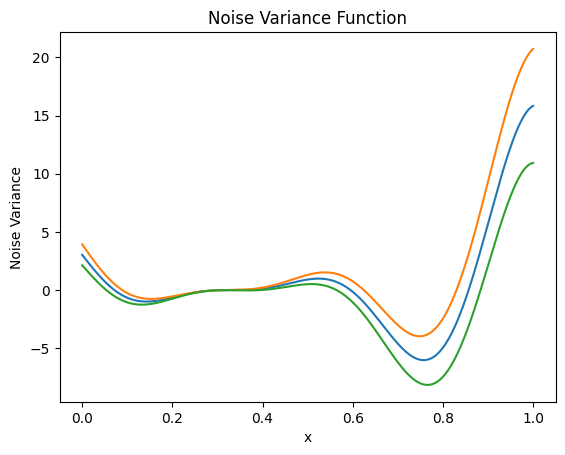

In [ ]:
# Grid values
x_grid = np.linspace(0, 1, 1000)
f_grid = calculate_y_true(x_grid)
noise_variance = noise_var_fun(x_grid)

# Sampling plan
x_doe = np.linspace(0, 1, 9)
print(x_doe)

# Observations
# y_doe = noise_var_fun(x_doe)

# Plot points
plt.plot(x_grid, f_grid)
plt.plot(x_grid, f_grid + noise_variance)
plt.plot(x_grid, f_grid - noise_variance)
# plt.scatter(x_doe, y_doe)
plt.xlabel('x')
plt.ylabel('Noise Variance')
plt.title('Noise Variance Function')
plt.show()

# Noisy function

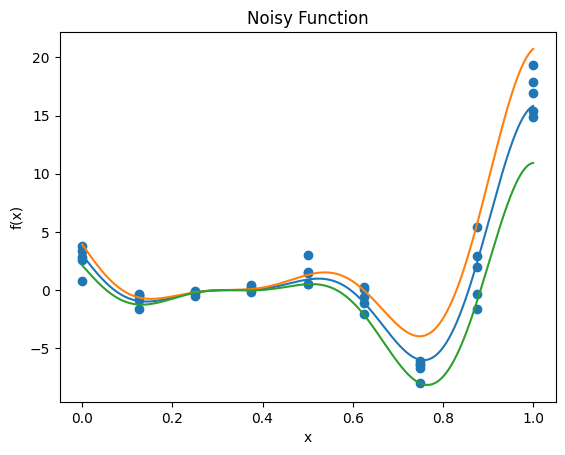

In [ ]:
x_doe5, y_doe5 = [], []
num_reps = 5
for i in range(len(x_doe)):
  for _ in range(num_reps):
    noise = noise_var_fun(x_doe[i])
    y = calculate_y_noisy(x_doe[i])
    x_doe5.append(x_doe[i])
    y_doe5.append(y)

x_doe5 = np.array(x_doe5)
y_doe5 = np.array(y_doe5)

# Check plot
plt.plot(x_grid, f_grid)
plt.plot(x_grid, f_grid + noise_variance)
plt.plot(x_grid, f_grid - noise_variance)
plt.scatter(x_doe5, y_doe5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Noisy Function')
plt.show()

In [ ]:
# Save x_doe5 and y_doe5 as columns in a CSV file named input.csv
df = pd.DataFrame({'x': x_doe5, 'y': y_doe5})
df.to_csv('input.csv', index=False)

In [ ]:
# Save x_unique, y_mean, y_var, n in a CSV file named output.csv
def process_csv(input_file, output_file):
  df = pd.read_csv(input_file)
  result = df.groupby('x')['y'].agg(['mean', 'var', 'count'])
  result.to_csv(output_file)

# Generate output.csv
process_csv('input.csv', 'output.csv')

In [ ]:
# From output.csv, obtain the values of the columns as np.arrays
df = pd.read_csv('output.csv')
xmean = df['x'].to_numpy()
ymean = df['y_mean'].to_numpy()
yvar = df['y_var'].to_numpy()

In [ ]:
# Train vanilla GP
f_model = train_gp_model(x_doe5.reshape(-1,1), y_doe5.reshape(-1,1), k='m32')
f_mean, f_var = f_model.predict_f(x_grid.reshape(-1,1))
f_mean = f_mean.numpy()
f_var = f_var.numpy()

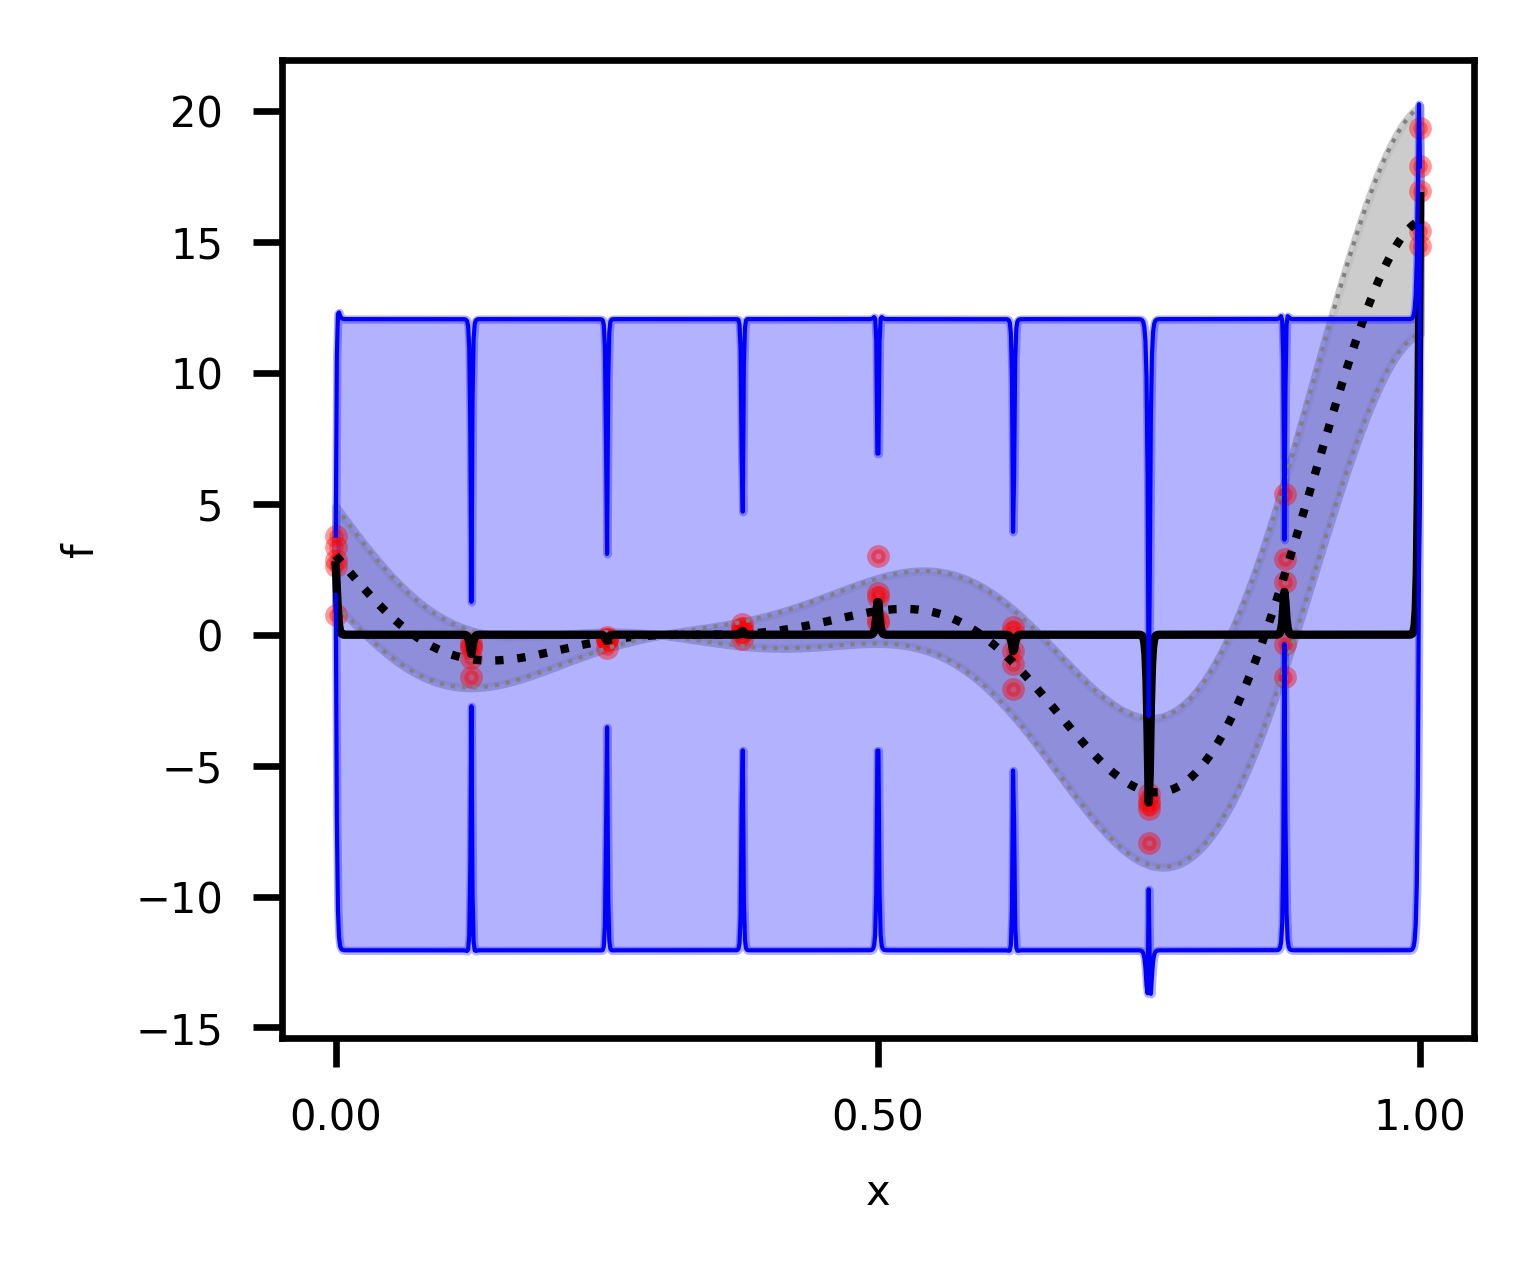

In [ ]:
# Plot
gp_noisy_plot(x_grid, f_grid, f_mean, f_var, noise_variance, x_doe5, y_doe5, dpi=200)

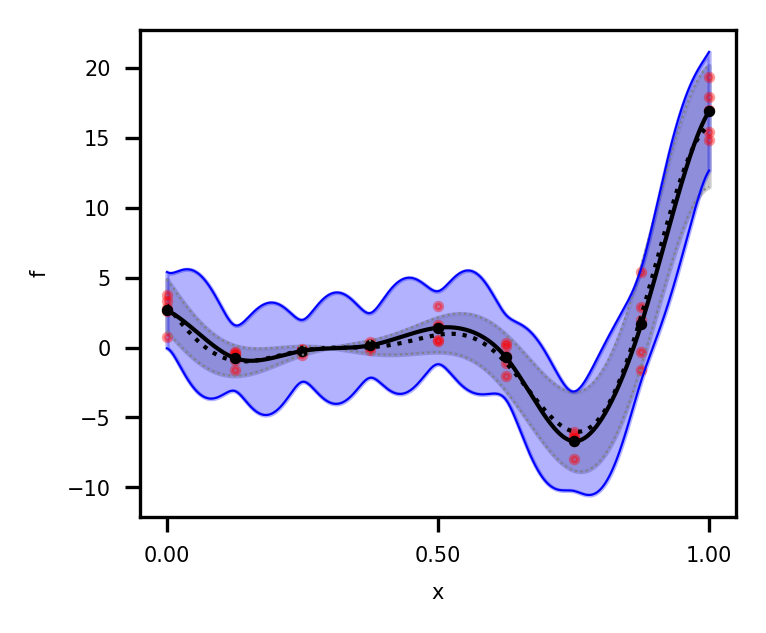

In [ ]:
# Heteroscedastic GP

# GP of the y mean
ymean_model = train_gp2_model(xmean.reshape(-1,1), ymean.reshape(-1,1), k='m32', lambda_=1e-3)
ymean_mean, ymean_var = ymean_model.predict_f(x_grid.reshape(-1,1))
ymean_mean = np.array(ymean_mean)
ymean_var = np.array(ymean_var)

# GP of the y var
# yvar_model = train_gp2_model(xmean.reshape(-1,1), yvar.reshape(-1,1), k='m32', lambda_=1e-3)
yvar_model = train_gp_model(xmean.reshape(-1,1), yvar.reshape(-1,1), k='m32')
yvar_mean, yvar_var = yvar_model.predict_f(x_grid.reshape(-1,1))
yvar_mean = np.array(yvar_mean)
yvar_var = np.array(yvar_var)

# Plot
gp_noisy_plot(x_grid, f_grid, ymean_mean, ymean_var + yvar_mean + yvar_var, noise_variance, x_doe5, y_doe5)
plt.scatter(xmean, ymean, s=3, color='k')
plt.show()

# Bayesian Optimization

In [ ]:
# Observations of the noiy function (in Step 2)
def fun_eval(x_doe, num_reps=5):
  x_reps, y_reps = [], []
  for pos in range(len(x_doe)):
    for _ in range(num_reps):
      y = calculate_y_noisy(x_doe[pos])
      x_reps.append(x_doe[pos])
      y_reps.append(y)
  return np.array(x_reps), np.array(y_reps)

In [ ]:
# Gather data (in Step 3) ---> to be replaced
def gather_data(data, num_reps=num_reps):
  samples = int(len(data)/num_reps)
  mean, var = [], []
  for k in range(samples):
    j = num_reps*k
    mean.append(np.mean(data[j:j+num_reps]))
    var.append(np.var(data[j:j+num_reps], ddof=1))
  return np.array(mean), np.array(var)

In [ ]:
def process_reps_csv(x_reps, y_reps, input_file, output_file):
  df = pd.DataFrame({'x': x_reps, 'y': y_reps})
  # Save input file
  df.to_csv(input_file, index=False)

  dfxyz = df.groupby('x')['y'].agg(['mean', 'var', 'count'])
  dfxyz = dfxyz.reset_index() # Reset the index to make 'x' a column again
  # Save output file
  dfxyz.to_csv(output_file, index=False)

  xmean = dfxyz['x'].to_numpy()
  ymean = dfxyz['mean'].to_numpy() # Access 'mean' column instead of 'y_mean'
  yvar = dfxyz['var'].to_numpy()  # Access 'var' column instead of 'y_var'

  return xmean, ymean, yvar

In [ ]:
def process_reps(x_reps, y_reps):
  df = pd.DataFrame({'x': x_reps, 'y': y_reps})
  dfxyz = df.groupby('x')['y'].agg(['mean', 'var', 'count'])
  dfxyz = dfxyz.reset_index() # Reset the index to make 'x' a column again
  xmean = dfxyz['x'].to_numpy()
  ymean = dfxyz['mean'].to_numpy() # Access 'mean' column instead of 'y_mean'
  yvar = dfxyz['var'].to_numpy()  # Access 'var' column instead of 'y_var'
  return xmean, ymean, yvar

In [ ]:
# Import the csv module
import csv
import os

# Number of iterations
num_outer_iter = 10 # 10
num_inner_iter = 31 # 26

# Check if the file exists and has content
filename = 'results.csv'
file_exists = os.path.isfile(filename) and os.path.getsize(filename) > 0
with open(filename, 'a', newline='') as f:
    writer = csv.writer(f)
    # Write header only if the file is new or empty
    if not file_exists:
        writer.writerow(['iter', 'x_best', 'y_best', 'max_ei'])
    # Write the data row
    # writer.writerow([iter, x_best, y_best, max_ei])

# Loop
for outer_iter in range(num_outer_iter):
  print('outer_iter=', outer_iter)

  # Step 1: Random sampling plan (5 points)
  distance = np.random.rand()/10 # distance
  distance = min(distance, 0.1)
  center_point = np.random.rand()*(1-4*distance)+2*distance # initial point
  x_doe = np.linspace(center_point-2*distance, center_point+2*distance, 5)
  x_doe = np.round(x_doe, 2)

  # Step 2: Observations of the noiy function
  x_reps, y_reps = fun_eval(x_doe, num_reps=5)

  # Loop
  for iter in range(num_inner_iter):

    # Step 3: Gather data
    # input_file = 'input_' + str(outer_iter) + '_' + str(inner_iter) + '.csv'
    # output_file = 'output' + str(outer_iter) + '_' + str(inner_iter) + '.csv'
    # xmean, ymean, yvar = process_reps_csv(x_reps, y_reps, input_file, output_file)
    xmean, ymean, yvar = process_reps(x_reps, y_reps)

    # Step 4: GP of ymean
    ymean_model = train_gp2_model(xmean.reshape(-1,1), ymean.reshape(-1,1), k='m32', lambda_=1e-3)
    ymean_mean, ymean_var = ymean_model.predict_f(x_grid.reshape(-1,1))
    ymean_mean = np.array(ymean_mean)
    ymean_var = np.array(ymean_var)

    # Step 5: GP of yvar
    yvar_model = train_gp_model(xmean.reshape(-1,1), yvar.reshape(-1,1), k='m32')
    yvar_mean, yvar_var = yvar_model.predict_f(x_grid.reshape(-1,1))
    yvar_mean = np.array(yvar_mean)
    yvar_var = np.array(yvar_var)

    # Step 6: Obtain the f(x_best)
    min_index = np.argmin(ymean)
    x_best = xmean[min_index]
    y_best = ymean[min_index]

    # Step 7: Lower confidence bound
    def get_lcb(kappa=2.0):
      lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
      min_lcb_index = np.argmin(lcb_grid)
      x_new_lcb = x_grid[min_lcb_index]
      return np.round(x_new_lcb, 2) # Rounded

    # Get LCB x_new point
    kappa = 1.0
    x_new_lcb = get_lcb(kappa=kappa)

    # Step 8: Expected improvement
    y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)
    ei_grid = expected_improvement(y_best, ymean_mean, y_std_hgp)
    max_ei_index = np.argmax(ei_grid)
    x_new_ei = x_grid[max_ei_index]
    x_new_ei = np.round(x_new_ei, 2) # Rounded

    # Step 9: Increase kappa until the two new points are different
    while x_new_lcb == x_new_ei and kappa < 100:
      # Adjust kappa to make them different
      kappa = 2*kappa
      print('kappa=', kappa)
      x_new_lcb = get_lcb(kappa=kappa)

    # Define x_new
    if x_new_lcb == x_new_ei:
      x_new = np.array([x_new_lcb])
    else:
      x_new = np.array([x_new_lcb, x_new_ei])

    # Step 10: Save results in a CSV file
    max_ei= np.max(ei_grid)
    print('iter=', outer_iter, iter)
    with open('results.csv', 'a') as f:
      writer = csv.writer(f)
      writer.writerow([iter, x_best, y_best, max_ei])

    # Step 11: Check for convergence
    if max_ei <= 0.1:
      print('Convergence')

    # Step 12: Observations of the new points
    x_new_reps, y_new_reps = fun_eval(x_new, num_reps=5)
    x_reps = np.concatenate((x_reps, x_new_reps))
    y_reps = np.concatenate((y_reps, y_new_reps))

  print('x_best = ', x_best)
  print('y_best = ', y_best)
  print('max_ei = ', max_ei)
  print('Finished with no issues')


outer_iter= 0
kappa= 2.0
iter= 0 0
kappa= 2.0
iter= 0 1
kappa= 2.0
kappa= 4.0
iter= 0 2
kappa= 2.0
kappa= 4.0
iter= 0 3
iter= 0 4
iter= 0 5
kappa= 2.0
iter= 0 6
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 0 7
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 8
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 9
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 0 10
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 11
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 0 12
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 0 13
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 14
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 15
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 16
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 17
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 18
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 19
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 20
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 0 21
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter=

<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 1


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 2


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 3
iter= 8 4
iter= 8 5
iter= 8 6


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 7


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 8


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 9


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 10


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 11


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 12


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 13


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 14


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 15


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 16


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 17


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 18


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 19


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 20


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 21


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 22


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 23


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 24


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 25


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 26


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 27


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 28


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 29


<ipython-input-191-337a5d1bcd71>:62: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean - kappa*np.sqrt(ymean_var + yvar_mean + yvar_var)
<ipython-input-191-337a5d1bcd71>:72: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var + yvar_mean + yvar_var)


kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
kappa= 64.0
kappa= 128.0
iter= 8 30
x_best =  0.73
y_best =  -5.990933784444257
max_ei =  nan
Finished with no issues
outer_iter= 9
kappa= 2.0
kappa= 4.0
iter= 9 0
kappa= 2.0
kappa= 4.0
iter= 9 1
kappa= 2.0
kappa= 4.0
iter= 9 2
kappa= 2.0
iter= 9 3
kappa= 2.0
kappa= 4.0
iter= 9 4
kappa= 2.0
kappa= 4.0
iter= 9 5
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 9 6
kappa= 2.0
iter= 9 7
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 9 8
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
kappa= 32.0
iter= 9 9
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 9 10
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 9 11
kappa= 2.0
iter= 9 12
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 9 13
kappa= 2.0
kappa= 4.0
kappa= 8.0
kappa= 16.0
iter= 9 14
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 9 15
kappa= 2.0
iter= 9 16
kappa= 2.0
kappa= 4.0
iter= 9 17
kappa= 2.0
kappa= 4.0
iter= 9 18
kappa= 2.0
kappa= 4.0
iter= 9 19
kappa= 2.0
kappa= 4.0
kappa= 8.0
iter= 9 20
k

In [ ]:
# Save x_reps and y_reps as columns in a CSV file named input.csv
dfxy = pd.DataFrame({'x': x_reps, 'y': y_reps})
dfxy.to_csv('input.csv', index=False)

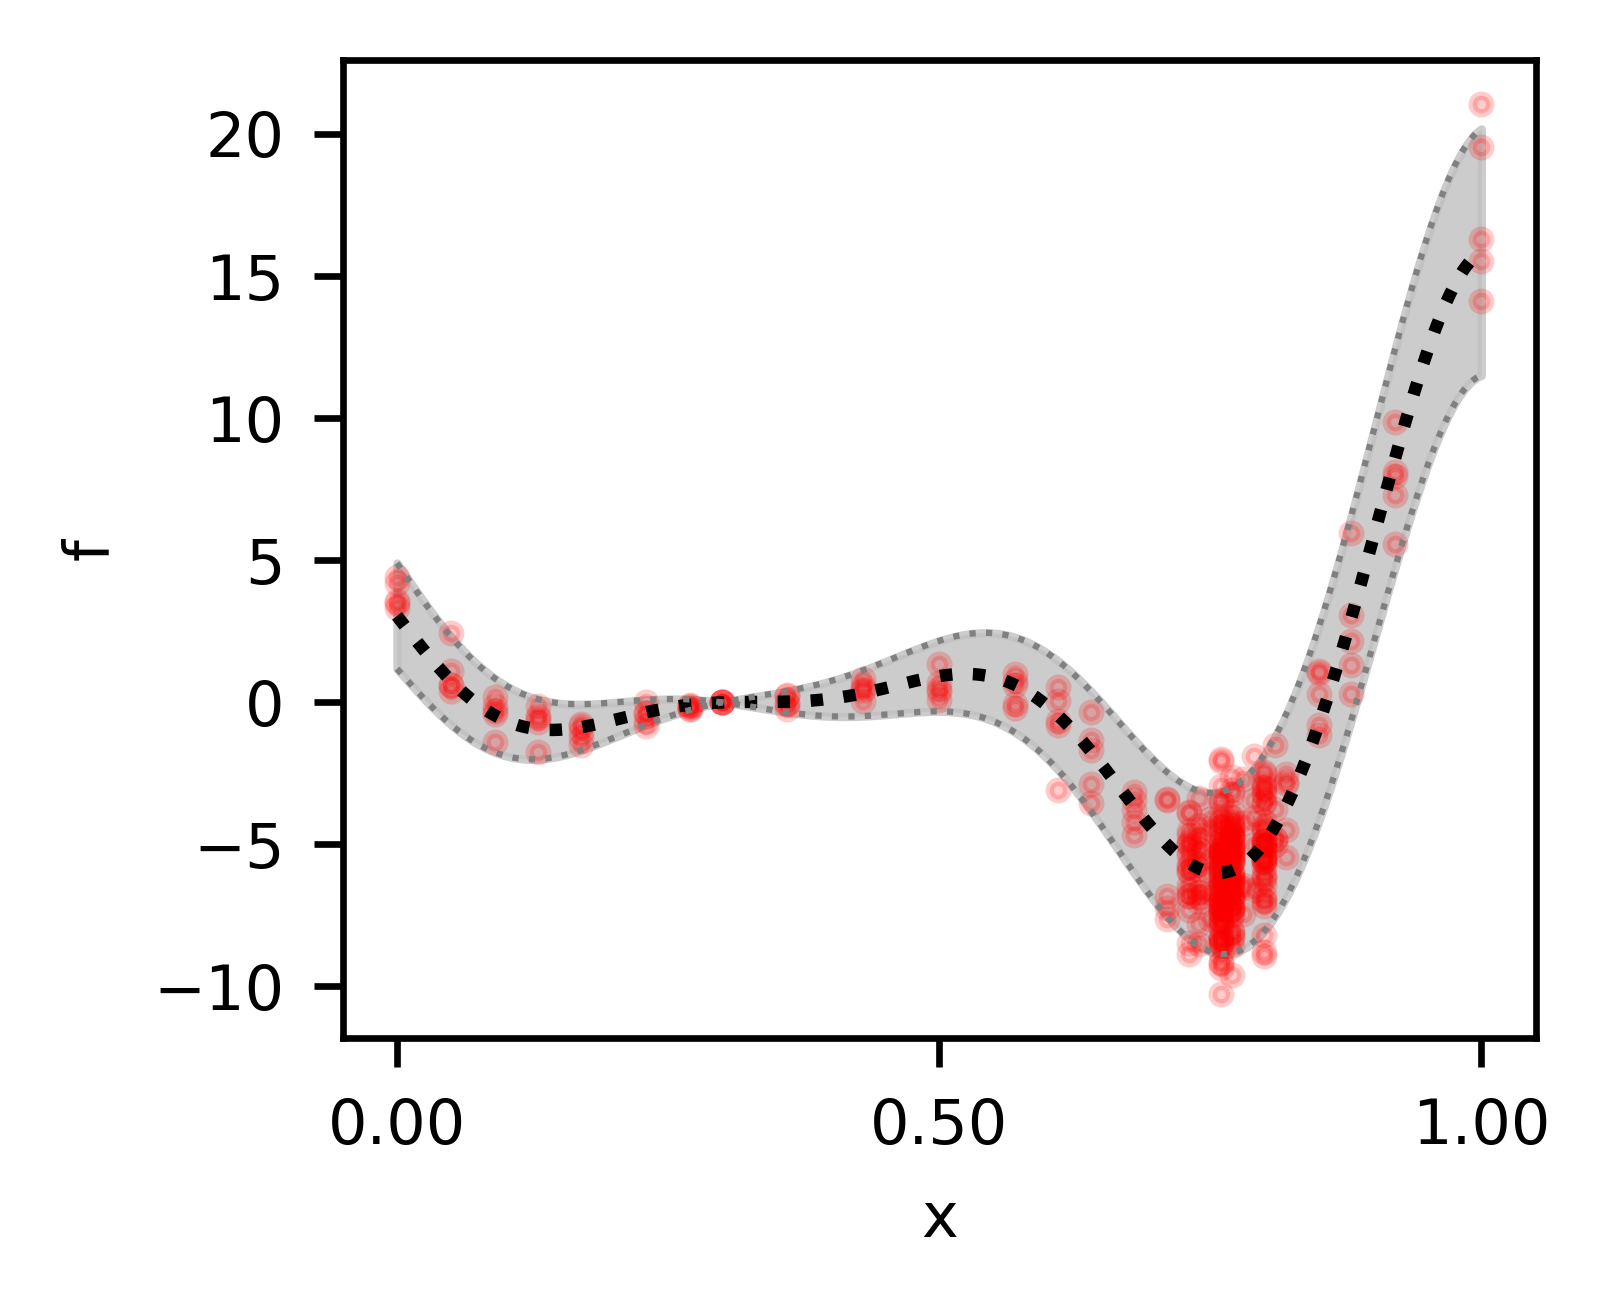

In [ ]:
def bo_noisy_plot(x_plot, y_true, y_var, x_scatter, y_scatter):
  # Plotting
  fontsize = 5/0.67
  linewidth = 1/0.67
  mark_size = 3/0.67

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=600)
  fig.tight_layout(pad=3.0)

  y_low = y_true - 1.96*np.sqrt(y_var)
  y_high  = y_true + 1.96*np.sqrt(y_var)

  # Plot true values
  ax.fill_between(x_plot.flatten(), y_low.flatten(), y_high.flatten(), color='silver', alpha=0.8)
  ax.plot(x_plot, y_true, color="k", linestyle=':', linewidth=linewidth, label='True Mean')
  ax.plot(x_plot, y_low, color="gray", linestyle=':', linewidth=linewidth/2, label='True LCB')
  ax.plot(x_plot, y_high, color="gray", linestyle=':', linewidth=linewidth/2, label='True UCB')

  ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("x", fontsize=fontsize)
  ax.set_ylabel("f", fontsize=fontsize)
  # ax.grid(True, which='major', color='gray', linestyle='--')

  ax.scatter(x_scatter, y_scatter, color="r", s=mark_size, label='Observed Points', alpha=0.2)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

# Plot
bo_noisy_plot(x_grid, f_grid, noise_variance, x_reps, y_reps)

In [ ]:
def iter_plot(iter, y_val, y_low, y_high, y_name='Values'):
  # Plotting
  fontsize = 5
  linewidth = 1
  mark_size = 5

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=300)
  fig.tight_layout(pad=3.0)

  ax.fill_between(iter, y_low, y_high, color='silver', alpha=0.5)
  ax.axhline(y=y_low, color='k', linestyle=':')
  ax.axhline(y=y_high, color='k', linestyle=':')
  ax.scatter(iter, y_val, color='r', s=mark_size, label='Observed Points', alpha=0.2)
  # ax.plot(iter, y_val, color='r', label='Observed Points', alpha=0.2)

  # ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("Iteration", fontsize=fontsize)
  ax.set_ylabel(y_name, fontsize=fontsize)

  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

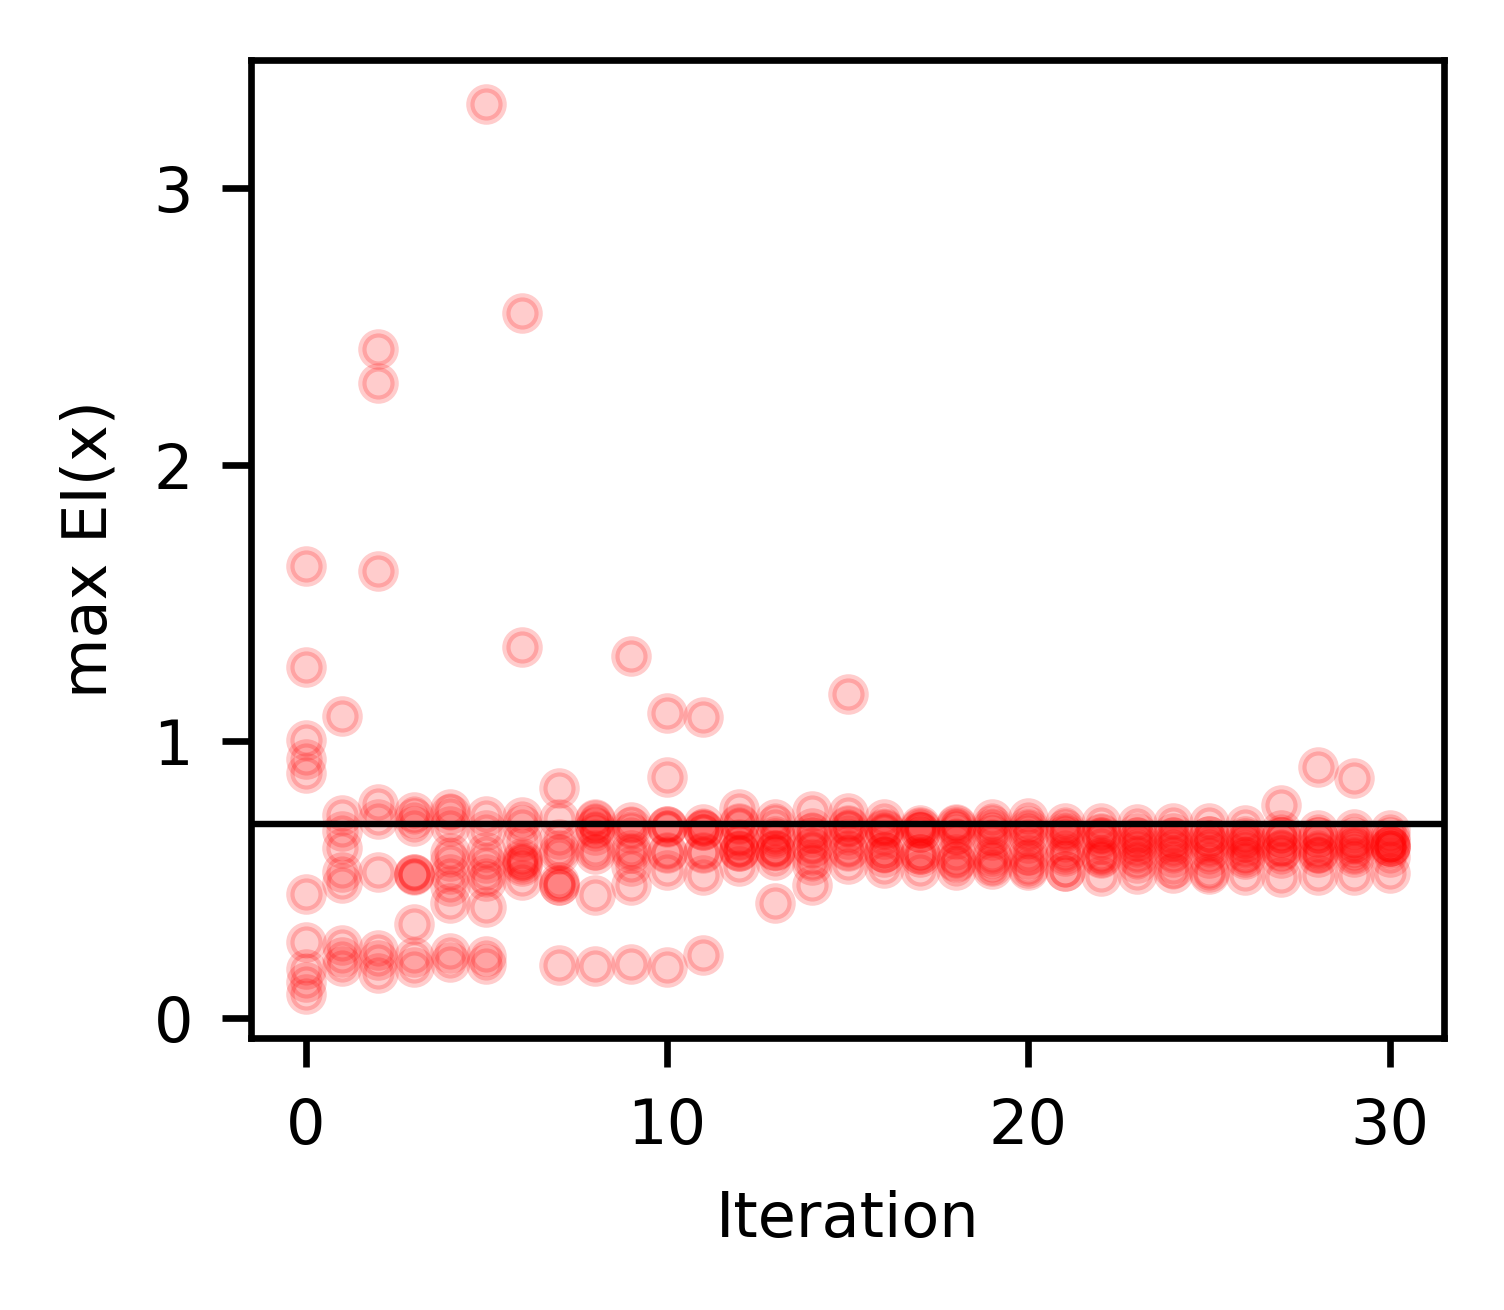

In [ ]:
def points_and_lines_plot(iter, y_val, y_low, y_high, y_name='Values'):
  # Plotting
  fontsize = 5/0.67
  linewidth = 1/0.67
  mark_size = 10/0.67

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=600)
  fig.tight_layout(pad=3.0)

  # ax.fill_between(iter, y_low, y_high, color='silver', alpha=0.5)
  ax.axhline(y=y_low, color='k', linestyle='-', linewidth=linewidth/2)
  ax.axhline(y=y_high, color='k', linestyle='-', linewidth=linewidth/2)
  ax.scatter(iter, y_val, color='r', s=mark_size, label='Observed Points', alpha=0.2)

  # ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("Iteration", fontsize=fontsize)
  ax.set_ylabel(y_name, fontsize=fontsize)

  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

# Plot
df = pd.read_csv('results.csv')
df = pd.DataFrame({'iter': df['iter'], 'max_ei': df['max_ei']})
points_and_lines_plot(iter=df['iter'], y_val=df['max_ei'], y_low=0.7, y_high=0.7, y_name='max EI(x)')

Confidence Interval:
Lower Bound: 0.7482
Upper Bound: 0.7662


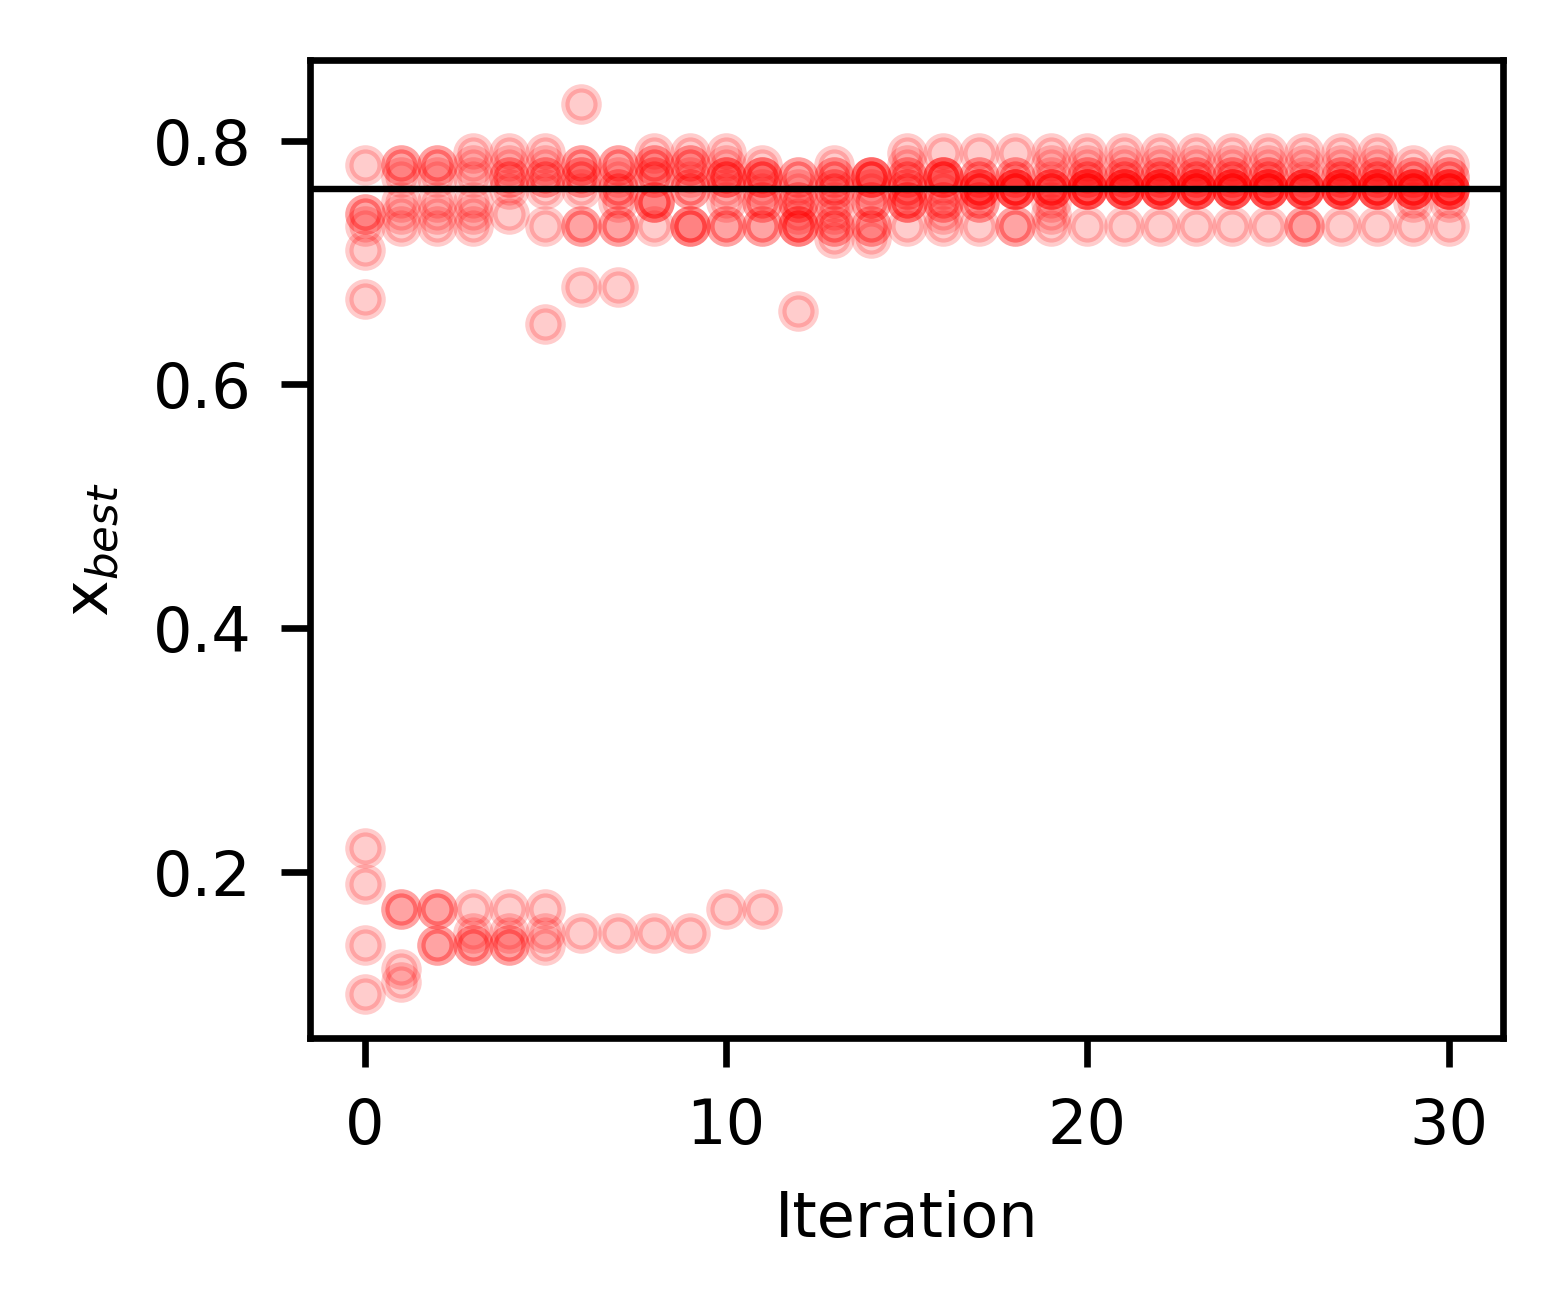

In [ ]:
# Confidence interval for sample size n=5, sample mean=0.7572, standard deviation=np.sqrt(10*(0.7572-0.3)**2), and user-defined confidence level
import scipy.stats as st

def confidence_interval(sample_mean, std_dev, sample_size, confidence_level):
  # Calculate the critical value (z-score)
  alpha = 1 - confidence_level
  critical_value = st.norm.ppf(1 - alpha / 2)

  # Calculate the margin of error
  margin_of_error = critical_value * (std_dev / np.sqrt(sample_size))

  # Calculate the confidence interval
  lower_bound = sample_mean - margin_of_error
  upper_bound = sample_mean + margin_of_error

  return lower_bound, upper_bound

# Given values
sample_mean = 0.7572
std_dev = np.sqrt(10 * (0.7572 - 0.3) ** 2)
sample_size = 1e5

# User-defined confidence level
confidence_level = 0.95  # Example: 95% or 99.99% confidence level

# Calculate the confidence interval
lower_bound, upper_bound = confidence_interval(sample_mean, std_dev, sample_size, confidence_level)

print("Confidence Interval:")
print(f"Lower Bound: {lower_bound:.4f}")
print(f"Upper Bound: {upper_bound:.4f}")

# Plot
df = pd.read_csv('results.csv')
df = pd.DataFrame({'iter': df['iter'], 'x_best': df['x_best']})
# iter_plot(iter=df['iter'], y_val=df['x_best'], y_low=lower_bound, y_high=upper_bound, y_name='x_best')
points_and_lines_plot(iter=df['iter'], y_val=df['x_best'], y_low=0.76, y_high=0.76, y_name='x$_{best}$')
